In [1]:
import numpy as np
import pandas as pd
import pickle
from keras.datasets import mnist
from matplotlib import pyplot as plt

#### Overview of the problem

The input is a black and white image of 28 by 28 pixels. The image contains digits from 0 to 10. The task is to match the symbol in the image with the digit as accurately as possible. The dataset contains labels for each image, which we will use to train the neural network.

#### Rectified Linear Unit (ReLU)

ReLU is an activation function for the first layer of our Neural Network. It is defined as positive part of its argument:
$$\begin{equation}
  f(x)=max(0,x)=\frac{x+|x|}{2}=
    \begin{cases}
      x & \text{if  $x>0$,}\\
      0 & \text{otherwise.}
    \end{cases}       
\end{equation}$$

In [2]:
def ReLU(Z):
    return np.maximum(Z, 0)

#### Derivative of Rectified Linear Unit

The derivative is pretty straight forward and is expressed by the following equation:
$$\begin{equation}
  f^{'}(x)=
    \begin{cases}
      x & \text{if $x>0$,}\\
      0 & \text{if $x<0$.}
    \end{cases}       
\end{equation}$$

In [3]:
def deriv_ReLU(Z):
    return Z > 0

#### Softmax

Sofmax is an activation function, that we use for the second layer of Neural Network. We can compute it using formula:
$$\frac{e^{z_{i}}}{\sum_{K}^{j=1}e^{z_{j}}}$$

In [4]:
def softmax(Z):
    exp = np.exp(Z - np.max(Z))
    return exp / exp.sum(axis=0)

#### Initial Parameters

We initialize our Neural Network with random parameters. We also normalize them.

In [5]:
def init_params(size):
    W1 = (np.random.rand(10, size) - 0.5) * np.sqrt(1./(784))
    b1 = (np.random.rand(10, 1) - 0.5) * np.sqrt(1./10)
    W2 = (np.random.rand(10, 10) - 0.5)  * np.sqrt(1./20)
    b2 = (np.random.rand(10, 1) - 0.5) * np.sqrt(1./(784))
    return W1, b1, W2, b2

#### Forward propagation

Input data is fed through a network, in a forward direction, to generate an output.

In [6]:
def forward_prop(X, W1, b1, W2, b2):
    Z1 = W1.dot(X) + b1 # 10, m
    A1 = ReLU(Z1) # 10, m
    Z2 = W2.dot(A1) + b2 # 10, m
    A2 = softmax(Z2) # 10, m
    return Z1, A1, Z2, A2

#### One Hot Encoding of Target Variable

We encode correct label of target variable into the second layer vector format using One Hot Encoding. For example, if we know that the picture represents 2, we want to encode the vector as [0, 0, 1, 0, 0, 0, 0, 0, 0, 0].

In [7]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.max() + 1, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y

#### Backpropagation

Backpropagation computes the gradient in weight space of a feedforward Neural Network.

In [8]:
def back_prop(X, Y, A1, A2, W2, Z1, m):
    one_hot_Y = one_hot(Y)
    dZ2 = 2 * (A2 - one_hot_Y) # 10, m
    dW2 = 1 / m * (dZ2.dot(A1.T)) # 10, 10
    db2 = 1 / m * np.sum(dZ2, 1) # 10, 1
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1) # 10, m
    dW1 = 1 / m * (dZ1.dot(X.T)) # 10, 784
    db1 = 1 / m * np.sum(dZ1, 1) # 10, 1
    return dW1, db1, dW2, db2

#### Updating Parameters

Since we know all the parameters now, all we need to do is to update parameters. We also apply learning rate $\alpha$ which is simply the step size at each iteration while moving towards a minimum of a loss function.

In [9]:
def update_params(alpha, W1, b1, W2, b2, dW1, db1, dW2, db2):
    W1 -= alpha * dW1
    b1 -= alpha * np.reshape(db1, (10, 1))
    W2 -= alpha * dW2
    b2 -= alpha * np.reshape(db2, (10, 1))
    return W1, b1, W2, b2

#### Get Predictions

This is a support function which converts the values of the probability vector obtained in the second layer of the Neural Network using the softmax function into a single output digit

In [10]:
def get_predictions(A2):
    return np.argmax(A2, 0)

#### Loss Function

As a loss function, we will use the simple ratio of the predicted digits to all the digits that the Neural Network received.

In [11]:
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

#### Neural Network body

The function is used as the body of the Neural Network. This function is responsible for iterations and is the entry point into the program. It is this function that should be called with initial parameters. It returns already trained parameters of the Neural Network, which can be used for prediction and determination of the final accuracy.

In [12]:
def gradient_descent(X, Y, alpha, iterations):
    size , m = X.shape
    W1, b1, W2, b2 = init_params(size)
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(X, W1, b1, W2, b2)
        dW1, db1, dW2, db2 = back_prop(X, Y, A1, A2, W2, Z1, m)
        W1, b1, W2, b2 = update_params(alpha, W1, b1, W2, b2, dW1, db1, dW2, db2)
        if (i+1) % int(iterations/10) == 0:
            print(f"Iteration: {i+1} / {iterations}")
            prediction = get_predictions(A2)
            print(f'{get_accuracy(prediction, Y):.3%}')
    return W1, b1, W2, b2

#### Helper-functions for outputting results

Functions that simplify inference. The first one is responsible for text output of the predicted digit. The second one outputs a picture for which Neural Network predicted the digit.

In [13]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(X, W1, b1, W2, b2)
    predictions = get_predictions(A2)
    return predictions

def show_prediction(index, X, Y, W1, b1, W2, b2):
    vector_X = X[:, index, None]
    prediction = make_predictions(vector_X, W1, b1, W2, b2)
    label = Y[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    current_image = vector_X.reshape((width, height)) * scale_factor
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

def show_wrong_prediction(X, Y, W1, b1, W2, b2, count=10):
    prediction = make_predictions(X, W1, b1, W2, b2)
    c = 0
    print(f"Model has {get_accuracy(prediction, Y)*100}% accuracy.")
    print(f"Drawing first {count} wrong predictions:\n")
    for i in range(len(prediction)):
        if c >= count: break
        if Y[i] != prediction[i]:
            print("Prediction: ", prediction[i])
            print("Label: ", Y[i])
            current_image = X[:, i, None].reshape((width, height)) * scale_factor
            plt.gray()
            plt.imshow(current_image, interpolation='nearest')
            plt.show()
            c += 1

#### Creating a dataset and splitting it into a training and test part

Even though our pictures are black and white, they still have 254 shades between white and black. We need to normalize these color values so that they belong to the interval from 0 to 1. To do this, we introduce a Scale Factor equal to 255. Thus white pixels will remain zeros, black pixels will remain ones, and all other shades will have numerical values in between.

In [14]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
scale_factor = 255
width = train_X.shape[1]
height = train_X.shape[2]
train_X = np.reshape(train_X, (train_X.shape[0], width*height)).T / scale_factor
test_X = np.reshape(test_X, (test_X.shape[0], width*height)).T / scale_factor

#### Neural Network training and validation on several examples

In [15]:
W1, b1, W2, b2 = gradient_descent(train_X, train_y, 0.17, 1000)
with open("trained_params.pkl", "wb") as dump_file:
    pickle.dump((W1, b1, W2, b2), dump_file)

Iteration: 100 / 1000
88.098%
Iteration: 200 / 1000
90.447%
Iteration: 300 / 1000
90.948%
Iteration: 400 / 1000
91.527%
Iteration: 500 / 1000
91.992%
Iteration: 600 / 1000
92.330%
Iteration: 700 / 1000
92.625%
Iteration: 800 / 1000
92.770%
Iteration: 900 / 1000
93.042%
Iteration: 1000 / 1000
93.222%


Prediction:  [7]
Label:  7


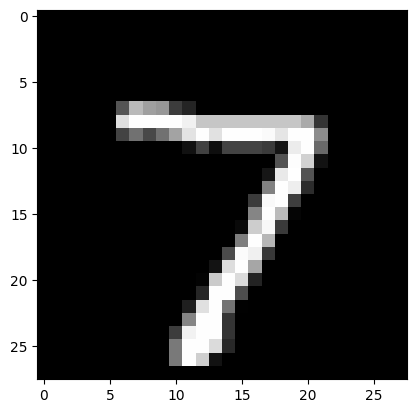

Model has 93.0% accuracy.
Drawing first 10 wrong predictions:

Prediction:  6
Label:  5


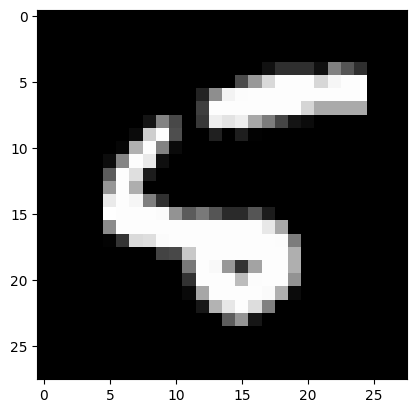

Prediction:  6
Label:  4


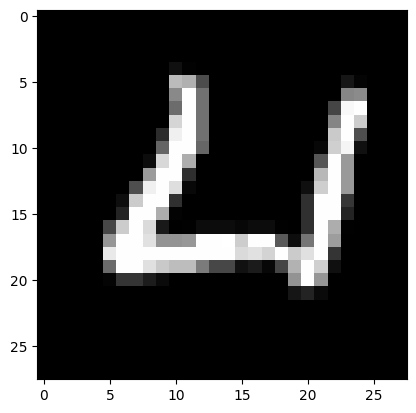

Prediction:  7
Label:  6


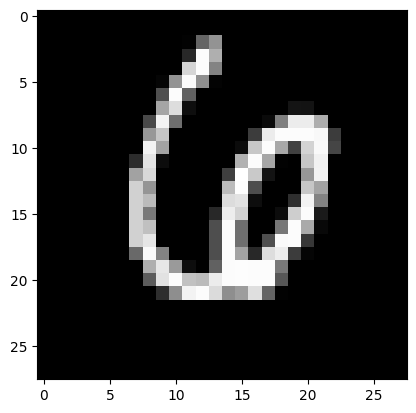

Prediction:  4
Label:  7


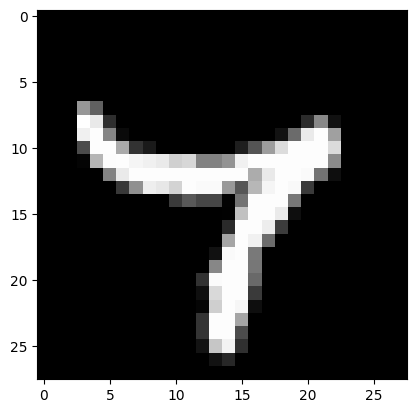

Prediction:  9
Label:  2


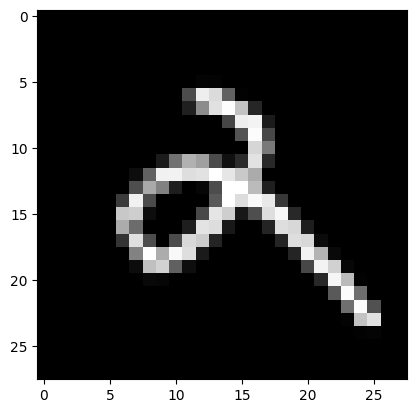

Prediction:  8
Label:  9


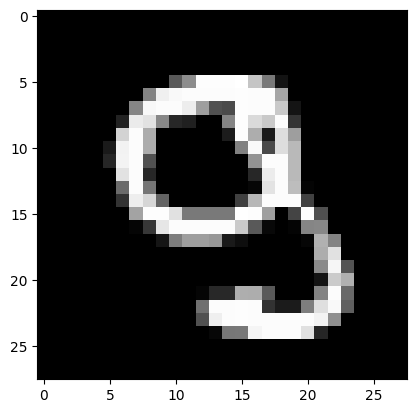

Prediction:  5
Label:  3


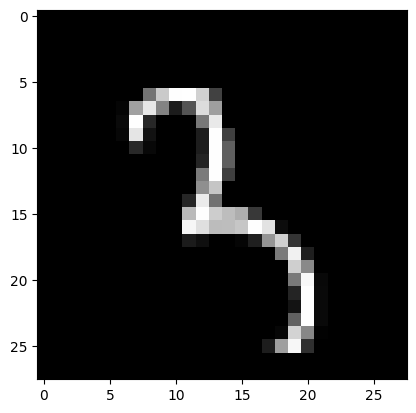

Prediction:  7
Label:  5


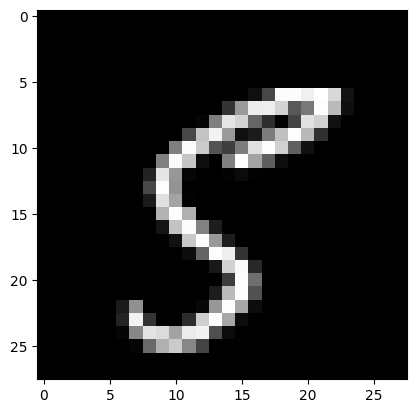

Prediction:  7
Label:  8


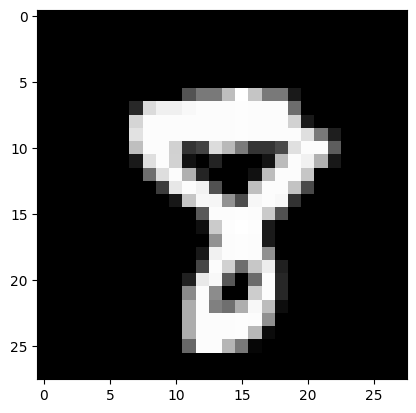

Prediction:  8
Label:  9


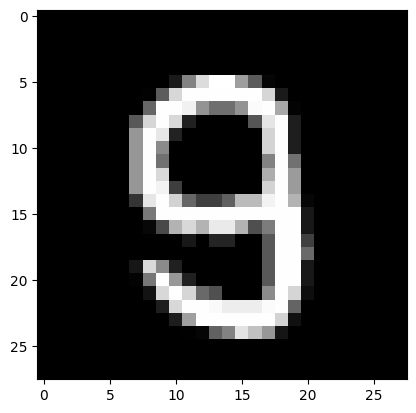

In [16]:
with open("trained_params.pkl", "rb") as dump_file:
    W1, b1, W2, b2 = pickle.load(dump_file)
show_prediction(0, test_X, test_y, W1, b1, W2, b2)
# show_prediction(1, test_X, test_y, W1, b1, W2, b2)
# show_prediction(2, test_X, test_y, W1, b1, W2, b2)
# show_prediction(100, test_X, test_y, W1, b1, W2, b2)
# show_prediction(200, test_X, test_y, W1, b1, W2, b2)
show_wrong_prediction(test_X, test_y, W1, b1, W2, b2)

#### Conclusion

We managed to get from Neural Network an accuracy of about 93%, which for such a simple network with such a small number of iterations is not a bad result in my opinion. Even when our Neural Network gives wrong answers, they are not mindless and we can see that the digits itself are not too obvious even for human to recognize. In any case, this result is very far from random guessing of numbers, which would give an accuracy of about 10%.